
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
#データの読み込み
age = pd.read_csv('Data\h27_age_df.csv')
family = pd.read_csv('Data\h27_family_df.csv')
gender = pd.read_csv('Data\h27_gender_df2.csv')
house= pd.read_csv('Data\h27_house_df.csv')
house_info = pd.read_csv('Data\h27_house_info_df.csv')
indusry = pd.read_csv('Data\h27_indusry_df.csv')
job = pd.read_csv('Data\h27_job_df.csv')
labor = pd.read_csv('Data\h27_labor_df.csv')
marriage = pd.read_csv('Data\h27_marriage_df.csv')
work_status = pd.read_csv('Data\h27_work_status_df.csv')
income = pd.read_csv('Data\income_district.csv')

国勢調査の小地域集計データでは、小地域ごとに年齢、家族構成、性別、住宅形態、職業、労働形態、配偶関係別の人数のデータが含まれている。地域はdistrict_idとdistrict2_idという2つのidで分類されており、district_idは標準地域コードを示している。level_identifierは分類の細かさを示しており、1が標準地域コードにしたがった市区町村単位の区分である。
また、小地域の収入データは以下のような分布であり、area_codeごとの収入の平均値のデータを示している。単位は(万円)。

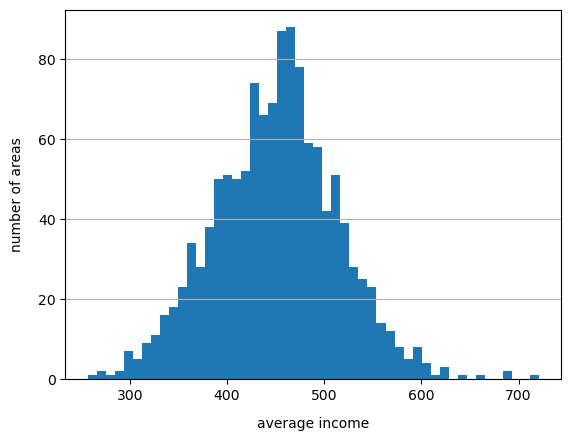

In [79]:
fig, ax = plt.subplots()
ax.hist(income["income_mean"], bins=50)
ax.set_xlabel('average income', fontsize=10,labelpad=10)
ax.set_ylabel('number of areas', fontsize=10,labelpad=10)
ax.tick_params(labelsize=10)
ax.grid(axis="y")

国勢調査の小地域集計データは全てdistrict_id, district2_id,state_name, district_name, city_name, district2_name, level_identifierという共通の列を持っている。これらを軸としてデータの結合を行う。

In [3]:
#小地域集計データの結合
df = pd.merge(age, family, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df2 = pd.merge(df, gender, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df3 = pd.merge(df2, house, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df4 = pd.merge(df3, house_info, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df5 = pd.merge(df4, indusry, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df6 = pd.merge(df5, job, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df7 = pd.merge(df6, labor, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df8 = pd.merge(df7, marriage, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])
df9 = pd.merge(df2, work_status, on=['district_id', 'district2_id','state_name', 'district_name', 'city_name', 'district2_name', 'level_identifier'])

income_districtにはarea_cordという列が存在する。これがdistrict_idと対応しており、国勢調査の小地域集計データとは単位が異なる。したがって推定に用いるデータはlevel_identifierが1のもののみとする。

In [4]:
df10 = df9[df9["level_identifier"]==1]
display(df10)

,district_id,district2_id,level_identifier,state_name,city_name,district_name,district2_name,10-14,15-19,20-24,...,female_population,family_count_y,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female
0,45201,NaN,1,宮崎県,宮崎市,NaN,NaN,19220,20777,17510,...,212961,175408,80219,13952,1541,2791,76534,3968,6097,2127
620,45202,NaN,1,宮崎県,都城市,NaN,NaN,7897,7689,6393,...,87508,69965,32431,7187,795,514,30615,1731,3380,379
886,45203,NaN,1,宮崎県,延岡市,NaN,NaN,5950,5980,4499,...,66166,51751,24474,4670,429,475,22419,1491,1723,316
1265,45204,NaN,1,宮崎県,日南市,NaN,NaN,2187,2294,1807,...,28716,22678,10444,2075,289,88,9339,610,1039,74
1548,45205,NaN,1,宮崎県,小林市,NaN,NaN,2056,1962,1279,...,24795,19498,8073,3119,407,176,8309,725,1798,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251086,8447,NaN,1,茨城県,稲敷郡河内町,NaN,NaN,347,437,381,...,4673,2950,2039,552,66,14,1674,95,228,10
251112,8521,NaN,1,茨城県,結城郡八千代町,NaN,NaN,1095,1071,1062,...,10712,6799,5147,1300,393,144,3637,190,878,97
251162,8542,NaN,1,茨城県,猿島郡五霞町,NaN,NaN,358,389,393,...,4378,2894,2194,399,54,57,1694,65,136,36
251181,8546,NaN,1,茨城県,猿島郡境町,NaN,NaN,1227,1175,1089,...,12300,8061,5619,1268,265,249,4451,222,797,143


In [5]:
#小地域の収入データと結合
df11 = pd.merge(df10, income, left_on="district_id", right_on="area_code")
display(df11)

,district_id,district2_id,level_identifier,state_name,city_name,district_name,district2_name,10-14,15-19,20-24,...,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,area_code,income_mean
0,45201,NaN,1,宮崎県,宮崎市,NaN,NaN,19220,20777,17510,...,80219,13952,1541,2791,76534,3968,6097,2127,45201,410.041038
1,45202,NaN,1,宮崎県,都城市,NaN,NaN,7897,7689,6393,...,32431,7187,795,514,30615,1731,3380,379,45202,347.089094
2,45203,NaN,1,宮崎県,延岡市,NaN,NaN,5950,5980,4499,...,24474,4670,429,475,22419,1491,1723,316,45203,363.127201
3,45204,NaN,1,宮崎県,日南市,NaN,NaN,2187,2294,1807,...,10444,2075,289,88,9339,610,1039,74,45204,361.800658
4,45205,NaN,1,宮崎県,小林市,NaN,NaN,2056,1962,1279,...,8073,3119,407,176,8309,725,1798,134,45205,345.428894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,8442,NaN,1,茨城県,稲敷郡美浦村,NaN,NaN,703,707,673,...,4122,561,55,17,2729,126,194,17,8442,470.108696
1234,8443,NaN,1,茨城県,稲敷郡阿見町,NaN,NaN,2183,2331,2528,...,11388,1453,162,352,8812,424,501,205,8443,445.899321
1235,8521,NaN,1,茨城県,結城郡八千代町,NaN,NaN,1095,1071,1062,...,5147,1300,393,144,3637,190,878,97,8521,526.232114
1236,8546,NaN,1,茨城県,猿島郡境町,NaN,NaN,1227,1175,1089,...,5619,1268,265,249,4451,222,797,143,8546,478.836317


最後に推定に用いるデータ以外を削除し、データの整形を終える。
'-'はデータが存在しないことを表しているので、これを0に置き換える。

In [80]:
df12 = df11.drop(['district2_id', 'level_identifier', 'district_name', 'district2_name',
				  'district_id', 'state_name', 'city_name', 'area_code'], axis=1)
df13 = df12.replace('-', 0)
display(df13)

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,...,family_count_y,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,income_mean
0,19220,20777,17510,18611,22131,26144,29081,25070,24686,25425,...,175408,80219,13952,1541,2791,76534,3968,6097,2127,410.041038
1,7897,7689,6393,7661,9132,9783,10200,8775,9707,11366,...,69965,32431,7187,795,514,30615,1731,3380,379,347.089094
2,5950,5980,4499,5139,6176,7096,7846,6846,7538,8356,...,51751,24474,4670,429,475,22419,1491,1723,316,363.127201
3,2187,2294,1807,1957,2548,2813,2904,2634,3242,4012,...,22678,10444,2075,289,88,9339,610,1039,74,361.800658
4,2056,1962,1279,1788,2315,2515,2475,2278,2722,3373,...,19498,8073,3119,407,176,8309,725,1798,134,345.428894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,703,707,673,668,933,1004,1187,1094,1097,1055,...,5958,4122,561,55,17,2729,126,194,17,470.108696
1234,2183,2331,2528,2370,2732,3164,3783,3103,2693,2883,...,18801,11388,1453,162,352,8812,424,501,205,445.899321
1235,1095,1071,1062,1197,1232,1425,1401,1249,1267,1586,...,6799,5147,1300,393,144,3637,190,878,97,526.232114
1236,1227,1175,1089,1111,1398,1543,1837,1554,1501,1660,...,8061,5619,1268,265,249,4451,222,797,143,478.836317


ここで、モデルの構築を行う前に相関行列を算出し、独立変数を選択する目安とする。また、ヒートマップを作成してそれぞれの変数の相関関係を視覚化する。

In [9]:
# 相関行列の算出
df13.corr()


,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,...,family_count_y,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,income_mean
10-14,1.000000,0.993712,0.948973,0.928778,0.937771,0.959670,0.973307,0.970021,0.975924,0.978428,...,0.948976,0.984819,0.937938,0.654178,0.747961,0.984638,0.927716,0.757812,0.723474,0.278068
15-19,0.993712,1.000000,0.970084,0.939145,0.943663,0.962824,0.975119,0.974165,0.980661,0.980352,...,0.959992,0.983103,0.935199,0.638634,0.766763,0.984973,0.932674,0.744436,0.745320,0.265180
20-24,0.948973,0.970084,1.000000,0.979191,0.974534,0.977370,0.977209,0.977825,0.977202,0.959780,...,0.981758,0.962304,0.902199,0.568831,0.857051,0.964888,0.937724,0.678970,0.841254,0.277685
25-29,0.928778,0.939145,0.979191,1.000000,0.996687,0.989005,0.979113,0.976787,0.973604,0.953138,...,0.987118,0.955119,0.898152,0.568639,0.895446,0.958200,0.947465,0.677691,0.880968,0.291124
30-34,0.937771,0.943663,0.974534,0.996687,1.000000,0.995911,0.985983,0.982979,0.979237,0.959483,...,0.989165,0.960639,0.904250,0.575194,0.891556,0.964052,0.953434,0.684599,0.878031,0.300676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
employer_female,0.984638,0.984973,0.964888,0.958200,0.964052,0.977444,0.982785,0.978837,0.987118,0.990846,...,0.975409,0.993478,0.951490,0.659880,0.780799,1.000000,0.957279,0.769911,0.761832,0.272825
self_employed_female,0.927716,0.932674,0.937724,0.947465,0.953434,0.958142,0.950520,0.950461,0.963038,0.964004,...,0.965867,0.937796,0.959578,0.684136,0.822753,0.957279,1.000000,0.800097,0.826322,0.232423
family_work_female,0.757812,0.744436,0.678970,0.677691,0.684599,0.699549,0.700207,0.696118,0.733056,0.783275,...,0.702737,0.746042,0.900118,0.961226,0.489287,0.769911,0.800097,1.000000,0.483004,0.072278
unkonwn_status_female,0.723474,0.745320,0.841254,0.880968,0.878031,0.856973,0.835332,0.839385,0.825507,0.778252,...,0.865752,0.744553,0.731243,0.388905,0.991038,0.761832,0.826322,0.483004,1.000000,0.211848


<Axes: >

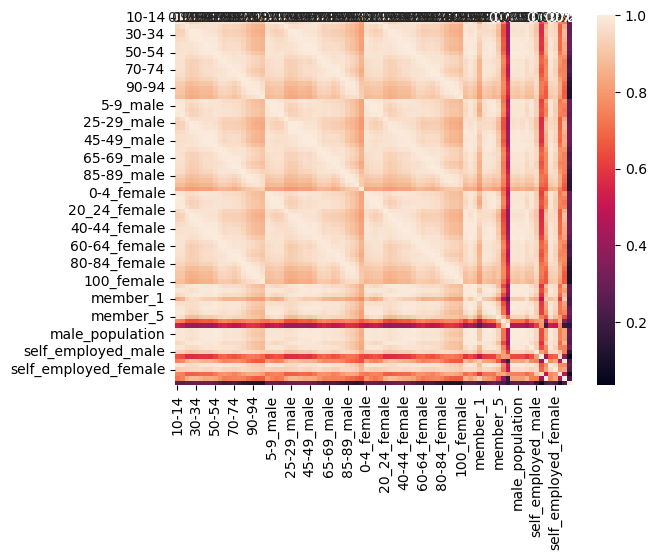

In [10]:
# 相関行列の算出
corr = df13.corr()
# ヒートマップの作成
sns.heatmap(corr, annot=True)

従属変数はincome_meanであるので、income_meanとそれぞれの変数の相関関係のみを再度表示する。

In [12]:
# 相関行列の算出
pd.set_option('display.max_rows', 100)
y_column='income_mean'
corr_matrix = df13.corr()
y_corr = corr_matrix[y_column]
y_corr

10-14                    0.278068
15-19                    0.265180
20-24                    0.277685
25-29                    0.291124
30-34                    0.300676
35-39                    0.307393
40-44                    0.310229
45-49                    0.307399
50-54                    0.280113
55-59                    0.232529
60-64                    0.200794
65-69                    0.217928
70-74                    0.224589
75-79                    0.191453
80-84                    0.155681
85-89                    0.134504
90-94                    0.119653
95-99                    0.115985
100                      0.109711
0-4_male                 0.296433
5-9_male                 0.290426
10-14_male               0.278279
15-19_male               0.265486
20_24_male               0.280886
25-29_male               0.299789
30-34_male               0.306743
35-39_male               0.311878
40-44_male               0.313644
45-49_male               0.315794
50-54_male    

次にモデルの構築を行う。独立変数として、相関係数が0.31以上のものからそれぞれが独立している変数を3つ選択した。40-44歳の人口、家族に4人目がいる世帯の数、男性の就業者の数である。推定したいincome_meanが離散データであることから、モデルとしては線形回帰を選択した。
まず、それぞれの相関係数を確認する。

In [81]:
df14 = df13[["40-44","member_4", "employer_male", "income_mean"]]
df14.corr()

,40-44,member_4,employer_male,income_mean
40-44,1.000000,0.985965,0.983520,0.310229
member_4,0.985965,1.000000,0.988473,0.316859
employer_male,0.983520,0.988473,1.000000,0.310620
income_mean,0.310229,0.316859,0.310620,1.000000


3つの独立変数の相関係数は非常に大きかった。これは人口が多いほどどの人数も多くなっていることが理由だと考えられる。

In [84]:
#モデルの構築
from sklearn.model_selection import train_test_split
X = df14.loc[:, ['40-44','member_4', 'employer_male']]
y = df14['income_mean']
assert len(X) == len(y)
y = np.array(y).reshape(-1,1)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)



In [15]:
#データの標準化処理
sc= StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [85]:
display(X_train_std)

array([[-0.09796518, -0.07632695,  0.0811686 ],
       [-0.61999413, -0.61907016, -0.63226184],
       [-0.62098407, -0.65543541, -0.65556125],
       ...,
       [ 1.2896023 ,  1.27948517,  1.49193251],
       [-0.47469277, -0.46250653, -0.51494043],
       [ 0.23135524, -0.14760926,  0.05843324]])

In [28]:
sc.fit(y_train)
y_train_std = sc.transform(y_train)
y_test_std = sc.transform(y_test)

In [83]:
model2=LinearRegression() # 線形回帰モデル
model2.fit(X_train_std,y_train_std) # モデルを訓練データに適合
y_predicted=model2.predict(X_test_std) # テストデータで予測
print("RMSE:", np.sqrt(((y_test_std - y_predicted)**2).mean()))# RMSE(平均二乗誤差のルート)で予測精度を評価する

RMSE: 0.9405942399989029


当てはまりを図として見るために、Xの次元を減らした新しいモデルを作成する。

In [17]:
#PCAを使用して次元を1次元まで減らす
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
X_train2 = pca.fit_transform(X_train_std)
X_test2 = pca.fit_transform(X_test_std)

In [18]:
X_test2.shape

(372, 1)

In [82]:
model=LinearRegression() # 線形回帰モデル
model.fit(X_train2,y_train_std) # モデルを訓練データに適合
y_predicted2=model.predict(X_test2) # テストデータで予測
print("RMSE:", np.sqrt(((y_test_std - y_predicted2)**2).mean()))# RMSEで予測精度を評価する

RMSE: 0.9361380031796074


C:\Users\Ruka\AppData\Local\Temp\ipykernel_2724\2999191953.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


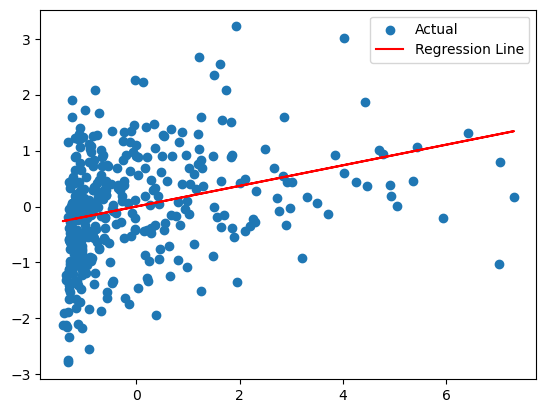

In [33]:
# 実際の値と予測値を重ねてプロットする
fig, ax = plt.subplots()
ax.scatter(X_test2, y_test_std, label='Actual')
ax.plot(X_test2, y_predicted2, c='red', label='Regression Line')
ax.legend()

fig.show()

図を見ると、ある程度実際の値を反映しているものの、このモデルはあまり当てはまりがよくないことがわかる。これは実際の値の分布が偏っていることが原因であると思われる。また、標準化したyについてRMSEが0.9を超えていることからも精度が高いとはいえない。
モデルを改善するには用いる変数やその数を変更する、独立変数のデータを人口に対する比率に変換する、線形回帰以外のモデルを用いるといった方法が考えられるだろう。